In [1]:
import numpy as np
from toy_datasets import *
import importlib  
# BootstrappedNonparametrics = importlib.import_module(, package="./Bootstrapped-Nonparametrics")
# from BootstrappedNonparametrics.nonparametrics import *
import os 
import math
import pdb
import random
import time
import multiprocessing as mp
from scipy.sparse import csr_matrix 
from scipy.sparse.csgraph import minimum_spanning_tree
from sklearn import mixture 
from joblib import  Parallel, delayed
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import scipy.io as sio
from scipy.spatial.distance import squareform
import math
import tqdm

/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/prad/anaconda3/envs/activelearn/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


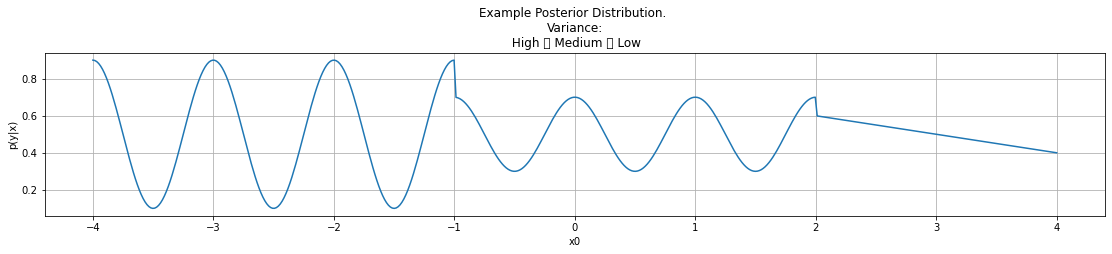

In [2]:
# ''' Oracle for the dataset'''


import ml_insights as mli
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import log_loss
import sklearn.metrics as skmetrics
from densityestimate import *

from classifier_utils import *
    

xvals = np.linspace(-4, 4, 500)
posteriorval = [oracle_sinusoid_posterior([_xval, 0]) for _xval in xvals]
plt.figure(figsize=(19,3))
plt.plot(xvals, posteriorval)
plt.ylabel('p(y|x)')
plt.xlabel('x0')
plt.title('Example Posterior Distribution. \nVariance:\n High \t Medium \t Low')
plt.grid()

In [3]:

sampsizes = [20, 30, 40, 50 ,60, 70, 100, 125, 150, 200, 250, 300, 375, 450, 550, 650, 750, 850, 950, 1000,
             1250, 1500, 1750, 2000, 2500, 3000, 3500, 3750, 4000, 4250, 4500, 5000, 5250, 5500, 6000, 7000, 10000, 20000]

# test_accuracies = svm

def generate_samples(n_samples):
    xdata = 8 * (np.random.rand(n_samples, 2)) - 4
    y_posterior = np.array([oracle_sinusoid_posterior(xdata[_ii]) for _ii in range(n_samples)])
    ylabel = np.array(y_posterior>.5).astype('float32')
#     ylabel = np.hstack([ylabel, np.abs(1-ylabel)])
    return xdata, y_posterior, ylabel

In [4]:
pdf1 = np.array([[0.,1., 0], [0.,0., 1.], [1., 0., 0.]])
pdf2 = np.array([[.25, .75, 0.],[0., .3, .7], [.66, 0, .34]])+1e-7
pdf2 = pdf2/np.sum(pdf2, axis=0)

print(skmetrics.log_loss(y_true=pdf1, y_pred=pdf2))
# print(np.mean(np.log10(pdf2)) - (1 - pdf1) * np.log10(1 - pdf2)) 

0.35044082567668733


In [6]:
#Test set
N_MC_ITERS = 25
N_SAMP_SIZES = len(sampsizes)

train_EPEs =  np.zeros([N_MC_ITERS, N_SAMP_SIZES])
test_EPEs = np.zeros([N_MC_ITERS, N_SAMP_SIZES])
train_xents = np.zeros([N_MC_ITERS, N_SAMP_SIZES])
test_xents = np.zeros([N_MC_ITERS, N_SAMP_SIZES])
train_accuracies = np.zeros([N_MC_ITERS, N_SAMP_SIZES])
test_accuracies = np.zeros([N_MC_ITERS, N_SAMP_SIZES])

classifier_list = []
data_list = []
normalizing_constants = []
test_datas = []
for ii in tqdm.tqdm(range(N_MC_ITERS)):
    tr_accs = []
    tr_mse = []

    acc_vals = []
    mse_vals = []
    datasets = []
    classifiers = []
    mu_std = []
    n_test = 1000
    xtest, te_posterior, yte_label = generate_samples(n_samples=n_test)
    
    for jj, N in enumerate(sampsizes):
        xtrain, tr_posterior, ytr_label = generate_samples(n_samples=N)
        mu = np.mean(xtrain, axis=0)
        std = np.std(xtrain, axis=0)
        mu_std.append([mu, std])
        _xtrain = (xtrain - mu)/std
        classifier = train_classifier(xtrain=_xtrain, ytrain=ytr_label, classifier='mlp')    
        datasets.append([_xtrain, ytr_label, tr_posterior])
        classifiers.append(classifier)
    #     svmclf.train(xtrain)

        _tr_acc = evaluate_classifier(classifier, _xtrain, ytr_label, accuracy)
        _tr_mse = evaluate_classifier(classifier, _xtrain, ytr_label, mse)

        _xtest = (xtest - mu)/std
        test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
        test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)

        train_xents[ii, jj] = evaluate_classifier(classifier, _xtrain, ytr_label, xentropy)
        test_xents[ii, jj] = evaluate_classifier(classifier, _xtest, yte_label, xentropy)
        
        tr_accs.append(_tr_acc)
        tr_mse.append(_tr_mse)

        acc_vals.append(test_acc)
        mse_vals.append(test_epe)
        xent_vals.append(test_xent)
        
    train_EPEs[ii, :] = tr_mse
    test_EPEs[ii, :] = mse_vals
    train_accuracies[ii, :] = tr_accs
    test_accuracies[ii, :] = acc_vals
    
    classifier_list.append(classifiers)
    data_list.append(datasets)
    normalizing_constants.append(mu_std)
    test_datas.append({'xtest': xtest, 'test_posterior':te_posterior, 'ytest': yte_label, 'test_xent':test_xents})

  0%|          | 0/25 [00:00<?, ?it/s]


NameError: name 'test_xent' is not defined

In [ ]:
idx = 0
print(datasets[idx][0].shape)

mu = mu_std[idx][0]
std = mu_std[idx][1]
_xtest = (xtest - mu)/std


plt.figure()
# plt.subplots(2, 1, 1)
plt.scatter(datasets[idx][0][:, 0], datasets[idx][0][:, 1], 
            c=datasets[idx][1])
plt.colorbar()
plt.grid()
plt.title('Train Data Labels')

plt.figure()
# plt.subplots(2, 1, 2)
plt.scatter(datasets[idx][0][:, 0], datasets[idx][0][:, 1], 
            c=classifiers[idx].predict_proba(datasets[idx][0])[:, 1]>.5)
plt.colorbar()
plt.grid()
plt.title('Train Data Predicted Labels')

plt.figure()
# plt.subplots(2, 1, 2)
plt.scatter(datasets[idx][0][:, 0], datasets[idx][0][:, 1], 
            c=classifiers[idx].predict_proba(datasets[idx][0])[:, 1])
plt.colorbar()
plt.grid()
plt.title('Train Data Predicted Probas')


plt.figure()
# plt.subplots(2, 1, 1)
plt.scatter(xtest[:, 0], xtest[:, 1], 
            c=classifiers[idx].predict_proba(_xtest)[:, 1])
plt.grid()
plt.colorbar()
plt.title('Test Data Predicted Probas')

plt.figure()
# plt.subplots(2, 1, 2)
plt.scatter(xtest[:, 0], xtest[:, 1], 
            c=classifiers[idx].predict_proba(_xtest)[:, 1]>.5)
plt.grid()
plt.colorbar()
plt.title('Test Data Predicted Labels')

In [ ]:
print(1-np.mean(test_accuracies, axis=0))
print(tr_accs)
[print(sampsizes[ii], 1-np.mean(test_accuracies[:, ii])) for ii in range(test_accuracies.shape[1])]

[55.700005 57.       55.5      54.100002 60.7      57.9      59.2
 65.9      65.       68.1      60.5      62.699997 67.1      64.4
 69.200005 63.4      67.9      64.5      65.3      67.299995 67.7
 82.5      74.3      84.5      81.4      85.299995 95.3      97.
 89.200005 97.       83.3      97.6      97.399994 98.799995 96.9
 97.2      98.4      97.2     ]


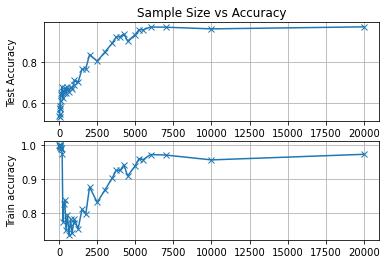

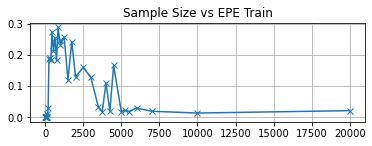

In [25]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(sampsizes, 1-np.mean(test_accuracies, axis=0), '-x')
plt.grid()
plt.title('Sample Size vs Accuracy')
plt.ylabel('Test Accuracy')
plt.subplot(2, 1, 2)
plt.plot(sampsizes, np.mean(train_accuracies, axis=0), '-x')
plt.ylabel('Train accuracy')
plt.grid()
# plt.title('Sample Size vs Accuracy Train')

plt.figure()
plt.subplot(2, 1, 1)

plt.plot(sampsizes, tr_mse, '-x')
plt.grid()
plt.title('Sample Size vs EPE Train')

print(100*(1-np.array(acc_vals)))

In [5]:
''' Step 2: Compare with uncertainty sampling'''
from scipy.stats import entropy

def argmin_logit_uncertainty_rank(xdata, predicted_probas, top_k, randomize=False, ignore_inds=None, uniform_frac=None):
    probainds = np.argmax(predicted_probas, axis=1)
    largest_logit = predicted_probas[np.arange(len(predicted_probas)), probainds]
    
    if randomize:
        largest_logit = largest_logit + np.random.randn(len(largest_logit))/120
    sortinds = np.argsort(largest_logit)
    
    if ignore_inds is not None:
        sortinds = np.delete(sortinds, ignore_inds)
        
    n_unif = 0 if uniform_frac is None else int(uniform_frac * top_k)     
    n_select = top_k - n_unif    
    
    selected_inds = sortinds[:n_select]
    if n_unif>0:
#         sortinds = np.delete(sortinds, selected_inds)
        # from the array of indices, select elements uniformly at random
        unif_inds = np.random.choice(sortinds[n_select:], n_unif, replace=False)
        selected_inds = np.concatenate([selected_inds, unif_inds])
    return selected_inds

def entropy_rank(xdata, ylogits, top_k):
    entropies = entropy(ylogits, axis-1)
    sortinds = np.argsort(entropies)
    selected_inds = sortinds[:top_k]
    selected_data = xdata[selected_inds]
    return selected_inds, selected_data

def uniform_sample(xdata, ylogits, nsample):
    sortinds = np.random.choice(np.arange(len(xdata)), nsample, replace=False)
    return xdata[sortinds], sortinds

# def importance_sample(xdata, n_sample, uniform_frac=None):
#     pass

In [6]:
np.delete([6, 5, 4, 3, 2, 1, 0], [6, 5])

array([6, 5, 4, 3, 2])

In [7]:
''' Step 2: Unlabled data querying '''

n_test = 5000
xtest, te_posterior, yte_label = generate_samples(n_samples=n_test)

N = 25000
xtrain, tr_posterior, ytr_label = generate_samples(n_samples=N)

mu = np.mean(xtrain, axis=0)
std = np.std(xtrain, axis=0)
# mu_std.append([mu, std])
_xtrain = (xtrain - mu)/std
classifier = train_classifier(xtrain=_xtrain, ytrain=ytr_label, classifier='mlp')    

_tr_acc = evaluate_classifier(classifier, _xtrain, ytr_label, accuracy)
_tr_mse = evaluate_classifier(classifier, _xtrain, ytr_label, mse)

_xtest = (xtest - mu)/std
test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)
print('Baseline training for %d data samples' % N)
print('Full dataset EPE', test_epe)
print('Full dataset Error', test_acc)

Baseline training for 25000 data samples
Full dataset EPE 0.9848
Full dataset Error 0.0152


In [9]:
"""
Seed accuracy
"""
print('Begin active learn Experiment')

# labled_fraction = .05
# n_seed = int(labled_fraction * N)
n_seed = 250
print('Selected %d seed points ' % n_seed)
xseed, seed_inds = uniform_sample(xdata=xtrain, ylogits=ytr_label, nsample=n_seed)
ytr_seed = ytr_label[seed_inds]
tr_seed_posterior = tr_posterior[seed_inds]

mu = np.mean(xseed, axis=0)
std = np.std(xseed, axis=0)
# mu_std.append([mu, std])
_xseed = (xseed - mu)/std
classifier = train_classifier(xtrain=_xseed, ytrain=ytr_seed, classifier='mlp')    

_tr_acc = evaluate_classifier(classifier, _xtrain, ytr_label, accuracy)
_tr_mse = evaluate_classifier(classifier, _xtrain, ytr_label, mse)

_xtest = (xtest - mu)/std
test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)
test_xent =  evaluate_classifier(classifier, _xtest, yte_label, xentropy)

print('Seed dataset test epe', test_epe)
print('Seed dataset test acc', 1-test_acc)
print('Seed dataset test xent', test_xent)

Begin active learn Experiment
Selected 250 seed points 
Seed dataset test epe 0.6214
Seed dataset test acc 0.621399998664856
Seed dataset test xent 16081.254


In [10]:
"""
Set up unlabled data 
"""
import matplotlib

# fraction_query = .075
MC_ITERS = 10
n_seed = 250
n_query = 100
nplots = 0
# PLOT = True
PLOT = False
BUDGET = 5000

active_accs = []
active_epes = []
active_xents = []
for MC in tqdm.tqdm(range(MC_ITERS)):
    xseed, seed_inds = uniform_sample(xdata=xtrain, ylogits=ytr_label, nsample=n_seed)
    selected_inds = seed_inds
    unlabled_inds = np.delete(np.arange(len(xtrain)), selected_inds)


    active_sampsize = []
    active_acc = []
    active_epe = []
    active_xent = []

    while len(selected_inds) < BUDGET:
        unlabled_inds = np.delete(np.arange(len(xtrain)), selected_inds)
        xunlabel = xtrain[unlabled_inds]
        ytr_unlabled = ytr_label[unlabled_inds]
        tr_unlabled_posterior = tr_posterior[unlabled_inds]

        xselected = xtrain[selected_inds]
        yselected = ytr_label[selected_inds]
        posterior_selected = tr_posterior[selected_inds]

        xstage1 = xselected
        ystage1 = yselected
        posterior_stage1 = posterior_selected

        # xtrain, tr_posterior, ytr_label = generate_samples(n_samples=N)
        mu = np.mean(xstage1, axis=0)
        std = np.std(xstage1, axis=0)
    #     mu_std.append([mu, std])
        _xstage1 = (xstage1 - mu)/std
        classifier = train_classifier(xtrain=_xstage1, ytrain=ystage1, classifier='mlp')    
        # _xstage1
        _tr_acc = evaluate_classifier(classifier, _xstage1, ystage1, accuracy)
        _tr_mse = evaluate_classifier(classifier, _xstage1, ystage1, mse)

        _xtest = (xtest - mu)/std
        test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
        test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)
        test_xent = evaluate_classifier(classifier, _xtest, te_posterior, xentropy)

        active_sampsize.append(len(selected_inds))
        active_acc.append(1-test_acc)
        active_epe.append(test_epe)
        active_xent.append(test_xent)
        print('active training, started w/ %d data samples, queried: %d, total %d ' % (len(selected_inds)-n_query,
                                                                                       n_query, len(selected_inds)))
        print('Active dataset EPE', test_epe)
        print('active dataset acc', 1-test_acc)
        print('active dataset xent', test_xent)



        """
        Select Samples (used in the next iteration)
        """


        pred_logits = classifier.predict_proba(_xtrain)
#         proba_noise = np.random.randn()
        min_logit_value_inds = argmin_logit_uncertainty_rank(xdata=xtrain, predicted_probas=pred_logits, randomize=False,
                                                                   top_k=n_query, ignore_inds=selected_inds, uniform_frac=.15)


        if nplots<15 and PLOT:
            plt.figure(figsize=(18, 4))
            plt.subplot(1, 3, 1)
            plt.scatter(xtrain[selected_inds, 0], xtrain[selected_inds, 1], marker='.', 
                        c=classifier.predict_proba(_xtrain)[selected_inds, 1], vmin=0., vmax=1.)
#                         c=classifier.predict_proba(_xtrain)[selected_inds, 1], cmap='hsv', vmin=0., vmax=1.)
#             plt.scatter(xtrain[min_logit_value_inds, 0], xtrain[min_logit_value_inds, 1], 
#                         c=np.ones_like(min_logit_value_inds), cmap='Greys', vmin=0., vmax=1., label='Selected')
            plt.grid()
#             plt.colorbar()
#             plt.colorbar(matplotlib.cm.ScalarMappable(cmap='hsv'))
            plt.colorbar()

            plt.title('Training Data Predicted Probas, %d Samp Size' % len(selected_inds))
            plt.ylim(-4.25, 4.25)
            plt.xlim(-4.25, 4.24)
#             plt.ylim(-2, 0)
#             plt.xlim(-2, 0)
#             plt.figure()
            plt.subplot(1, 3, 2)
#             plt.scatter(xtrain[selected_inds, 0], xtrain[selected_inds, 1], 
#                         c=classifier.predict_proba(_xtrain)[selected_inds, 1], cmap='hsv', vmin=0., vmax=1., label='Train')
#             plt.scatter(xtrain[:, 0], xtrain[:, 1], marker='.',
#                         c=classifier.predict_proba(_xtrain)[:, 1], cmap='hsv', vmin=0., vmax=1., label='Train')
#                         c=classifier.predict_proba(_xtrain)[:, 1], vmin=0., vmax=1., label='Train')
#             wts = classifier.predict_proba(_xtrain)[:, 1]
#             inds = np.argwhere(np.abs(wts-.5)<.1)
#             print(len(inds))
            plt.scatter(xtest[:, 0], xtest[:, 1], 
                        c=classifier.predict_proba(_xtest)[:, 1], cmap='hsv', vmin=0., vmax=1., label='Test')
#                         c=classifier.predict_proba(_xtest)[:, 1], vmin=0., vmax=1., label='Test')

#             plt.scatter(xtrain[min_logit_value_inds, 0], xtrain[min_logit_value_inds, 1], 
#                         c=np.ones_like(min_logit_value_inds), cmap='Greys', vmin=0., vmax=1., label='Selected')
            plt.legend()
            plt.grid()
#             plt.colorbar(matplotlib.cm.ScalarMappable(cmap='hsv'))
            plt.title('All Available Points (From Prev Round)')
            plt.colorbar()
            plt.ylim(-4.25, 4.25)
            plt.xlim(-4.25, 4.24)
#             plt.ylim(-2, 0)
#             plt.xlim(-2, 0)
            plt.subplot(1, 3, 3)
#             plt.scatter(xtrain[selected_inds, 0], xtrain[selected_inds, 1], 
#                         c=classifier.predict_proba(_xtrain)[selected_inds, 1], cmap='hsv', vmin=0., vmax=1., label='Train')
#             plt.scatter(xtrain[:, 0], xtrain[:, 1], 
#                         c=classifier.predict_proba(_xtrain)[:, 1], cmap='hsv', vmin=0., vmax=1., label='Train')
#             plt.scatter(xtest[:, 0], xtest[:, 1], 
#                         c=classifier.predict_proba(_xtest)[:, 1], cmap='hsv', vmin=0., vmax=1., label='Test')

#             pred_logits = classifier.predict_proba(_xtrain)
#             probainds = np.argmax(pred_logits, axis=1)
#             largest_logit = pred_logits[np.arange(len(pred_logits)), probainds]
#             sortinds = np.argsort(largest_logit)
#             print(len(sortinds))
#             sortinds = np.delete(sortinds, selected_inds)
#             print(len(sortinds))
#             if ignore_inds is not None:
#                 sortinds = np.delete(sortinds, ignore_inds)
#             inds = sortinds[:n_query]

            plt.scatter(xtrain[min_logit_value_inds, 0], xtrain[min_logit_value_inds, 1], marker='.', 
                        c=np.ones_like(min_logit_value_inds), cmap='Greys', vmin=0., vmax=1., label='Selected')
            plt.legend()
            plt.grid()
#             plt.colorbar(matplotlib.cm.ScalarMappable(cmap='hsv'))
            plt.title('Selected Points')
            plt.colorbar()
            plt.ylim(-4.25, 4.25)
            plt.xlim(-4.25, 4.24)
#             plt.ylim(-2, 0)
#             plt.xlim(-2, 0)
            plt.show()
            nplots+=1
#         if nplots>10:
#             print('asdf')
#             print(jkj094)

        selected_inds = np.concatenate([selected_inds, min_logit_value_inds])

    active_epes.append(active_epe)
    active_accs.append(active_acc)
    active_xents.append(active_xent)


  0%|          | 0/10 [00:00<?, ?it/s]


NameError: name 'yte_posterior' is not defined

In [1]:
import seaborn as sns
# sns.lineplot

In [2]:
result_active_epe = np.array(np.shape(active_epes))
# result_active

NameError: name 'np' is not defined

In [13]:
"""
UNIFORM QUERYING
Set up unlabled data 
"""
MC_ITERS = 10
n_seed = 250
n_query = 100
nplots = 0
PLOT = False

knnkde_accs = []
# unifdraw_accs = []

for MC in tqdm.tqdm(range(MC_ITERS)):
    # active_sampsize.append(len(selected_inds))
#     unif_acc.append(1-test_acc)
#     unif_epe.append(test_epe)
#     unif_xent.append()
    
    unif_acc = []
    unif_epe = []
    unif_xent = []    
    selected_inds = seed_inds
    unlabled_inds = np.delete(np.arange(len(xtrain)), selected_inds)
    
    while len(selected_inds) < BUDGET:
        unlabled_inds = np.delete(np.arange(len(xtrain)), selected_inds)
        xunlabel = xtrain[unlabled_inds]
        ytr_unlabled = ytr_label[unlabled_inds]
        tr_unlabled_posterior = tr_posterior[unlabled_inds]

        """
        Run first round of active query
        """


        pred_logits = classifier.predict_proba(xunlabel)

        xselected = xtrain[selected_inds]
        yselected = ytr_label[selected_inds]
        posterior_selected = tr_posterior[selected_inds]

        xstage1 = xselected
        ystage1 = yselected
        posterior_stage1 = posterior_selected

        # xtrain, tr_posterior, ytr_label = generate_samples(n_samples=N)
        mu = np.mean(xstage1, axis=0)
        std = np.std(xstage1, axis=0)
    #     mu_std.append([mu, std])
        _xstage1 = (xstage1 - mu)/std
        classifier = train_classifier(xtrain=_xstage1, ytrain=ystage1, classifier='mlp')    
        # _xstage1
        _tr_acc = evaluate_classifier(classifier, _xstage1, ystage1, accuracy)
        _tr_mse = evaluate_classifier(classifier, _xstage1, ystage1, mse)

        _xtest = (xtest - mu)/std
        test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
        test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)
        test_xent = evaluate_classifier(classifier, _xtest, te_posterior, xentropy)

        unif_acc.append(1-test_acc)
        unif_epe.append(test_epe)
        unif_xent.append(test_xent)

#         print('Unif training, started w/ %d data samples, queried: %d, total %d ' % (len(selected_inds)-n_query,
#                                                                                        n_query, len(selected_inds)))
#         print('Unif dataset EPE', test_epe)
#         print('Unif dataset acc', 1-test_acc)


        unif_inds = np.random.choice(unlabled_inds, n_query)


        if nplots<15 and PLOT:
            plt.figure(figsize=(18, 4))
            plt.subplot(1, 3, 1)
            plt.scatter(xtrain[selected_inds, 0], xtrain[selected_inds, 1], marker='.', 
                        c=classifier.predict_proba(_xtrain)[selected_inds, 1], vmin=0., vmax=1.)
            plt.grid()
            plt.colorbar()
            plt.title('Training Data Predicted Probas, %d Samp Size' % len(selected_inds))
            plt.ylim(-4.25, 4.25)
            plt.xlim(-4.25, 4.24)

            plt.subplot(1, 3, 2)
            plt.scatter(xtest[:, 0], xtest[:, 1], 
                        c=classifier.predict_proba(_xtest)[:, 1], cmap='hsv', vmin=0., vmax=1., label='Test')
            plt.legend()
            plt.grid()
    #             plt.colorbar(matplotlib.cm.ScalarMappable(cmap='hsv'))
            plt.title('All Available Points (From Prev Round)')
            plt.colorbar()
            plt.ylim(-4.25, 4.25)
            plt.xlim(-4.25, 4.24)

            plt.subplot(1, 3, 3)
            plt.scatter(xtrain[unif_inds, 0], xtrain[unif_inds, 1], marker='.', 
                        c=np.ones_like(unif_inds), cmap='Greys', vmin=0., vmax=1., label='Selected')
            plt.legend()
            plt.grid()
    #             plt.colorbar(matplotlib.cm.ScalarMappable(cmap='hsv'))
            plt.title('Selected Points (Uniform Sampling)')
            plt.colorbar()
            plt.ylim(-4.25, 4.25)
            plt.xlim(-4.25, 4.24)
            plt.show()
            nplots+=1

        selected_inds = np.concatenate([selected_inds, unif_inds])
    unif_accs.append(unif_acc)
    unif_epes.append(unif_epe)
    unif_xents.append(unif_xent)

Text(0, 0.5, 'Test Accuracy')

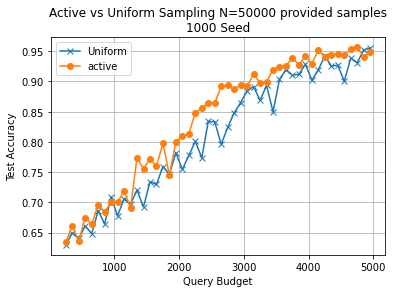

In [27]:
''' Plot Unif sampling vs uncertain sapmling '''
plt.plot(active_sampsize[1:], np.mean(unif_epes, axis=0)[1:], '-x', label='Uniform')
plt.plot(active_sampsize[1:], np.mean(active_epes, axis=0)[1:], '-o', label='active')
plt.legend()
plt.grid()
plt.title('Active vs Uniform Sampling N=50000 provided samples\n1000 Seed')
plt.xlabel('Query Budget')
plt.ylabel('Test Accuracy')

In [ ]:
unif_var = np.std(unif_epes, axis=0)
print(unif_var)

Text(0, 0.5, 'Test Accuracy')

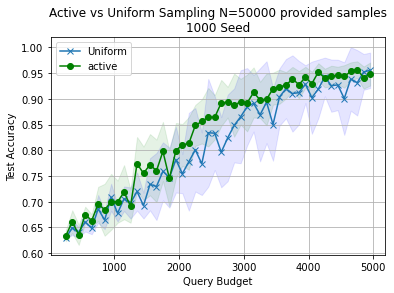

In [48]:
''' Plot Unif sampling vs uncertain sapmling '''
unif_mean = np.mean(unif_epes, axis=0)[1:]
unif_var = np.std(unif_epes, axis=0)[1:]
active_mean = np.mean(active_epes, axis=0)[1:]
active_var = np.std(active_epes, axis=0)[1:]
plt.plot(active_sampsize[1:], unif_mean, '-x', label='Uniform')
plt.fill_between(active_sampsize[1:], unif_mean-unif_var, unif_mean+unif_var, color='b', alpha=.1)
plt.plot(active_sampsize[1:], active_mean, '-o', label='active', color='g')
plt.fill_between(active_sampsize[1:], active_mean-active_var, active_mean+active_var, color='g', alpha=.1)
plt.legend()
plt.grid()
plt.title('Active vs Uniform Sampling N=50000 provided samples\n1000 Seed')
plt.xlabel('Query Budget')
plt.ylabel('Test Accuracy')

In [14]:
''' Sampling function '''

def simple_knn_posterior_estimate(data, labels, k, kernel=None, input_posterior=None):
    '''
    data - [n_points, n_dimensions]
    labels - [n_points, 2]
    '''
    
    def _compute_ber(neighbdata, neighborlabels, centerlabel):
        errors = np.sum(np.abs(neighborlabels - centerlabel))
#         print(errors)
        N = np.sum(neighborlabels==0)
        M = np.sum(neighborlabels==1)
        if N==0 or M==0:
            kerneldp = 1.
            kernelBayesLB = 0.
        else:
            kerneldp = 1 - ((M + N) / (2 * M * N)) * errors
            if kerneldp<=0:
                kerneldp=0.
                kernelBayesLB = 0
            else:
                kernelBayesLB = .5 - .5 * np.sqrt(kerneldp)
        return kernelBayesLB
    
    def _compute_1nn_threshold():
        nbrs = NearestNeighbors(n_neighbors = k + 1).fit(data)
        distances, inds = nbrs.kneighbors(data)
        
        
    n_points = data.shape[0]
    nbrs = NearestNeighbors(n_neighbors = k + 1).fit(data)
    distances, inds = nbrs.kneighbors(data)
    posterior_value = np.zeros([n_points,1])
    ber_estimates = np.zeros([n_points, 1])
    posterior_var = np.zeros([n_points,1])
    posterior_thresh = np.zeros([n_points, 1])
    ber_var = np.zeros([n_points, 1])
    
    for ii in range(n_points):
        neighblabels = labels[inds[ii, ]]
        neighbdata = data[inds[ii,:]]
        posterior_value[ii] = sum(neighblabels[1:])/k
        ber_estimates[ii] = _compute_ber(neighbdata[1:], neighblabels[1:], neighblabels[0])
    
    
    if input_posterior is not None:
        posterior_value = input_posterior
        
    for ii in range(n_points):
        neighb_ber = ber_estimates[inds[ii, :]]
        neighb_posterior= posterior_value[inds[ii, :]]
        ber_var[ii] = np.var(neighb_ber[1:])
        posterior_var[ii] = np.var(neighb_posterior[1:])
        posterior_thresh[ii] = sum(neighb_posterior[1:]-neighb_posterior[0]>(1/k))
    return posterior_value, ber_estimates, posterior_var, ber_var, posterior_thresh


def get_coreset(weights, Mc, smoothing = True, alpha=None):
    # input_data - n_samp x n_features    
    inds = np.arange(weights.shape[0])
    sampling_pmf = weights.ravel()
    if smoothing:
        smoothing_pmf = 1/weights.shape[0] 
        
        if alpha is not None:
            sampling_pmf = weights + alpha * smoothing_pmf
        
    sampling_pmf = sampling_pmf/sum(sampling_pmf)
    
    coreset_inds = np.random.choice(inds, size=Mc, replace=True, p=sampling_pmf)

In [15]:
trposterior, trber, knn_kde_weights_estimated, trber_variance, trposterior_thresh = simple_knn_posterior_estimate(data=xtrain, labels=ytr_label, k=30)
trposterior, trber, knn_kde_oracle_weights, trber_variance, trposterior_thresh = simple_knn_posterior_estimate(data=xtrain, 
                                                                                                               labels=ytr_label, k=30, 
                                                                                                              input_posterior=tr_posterior)

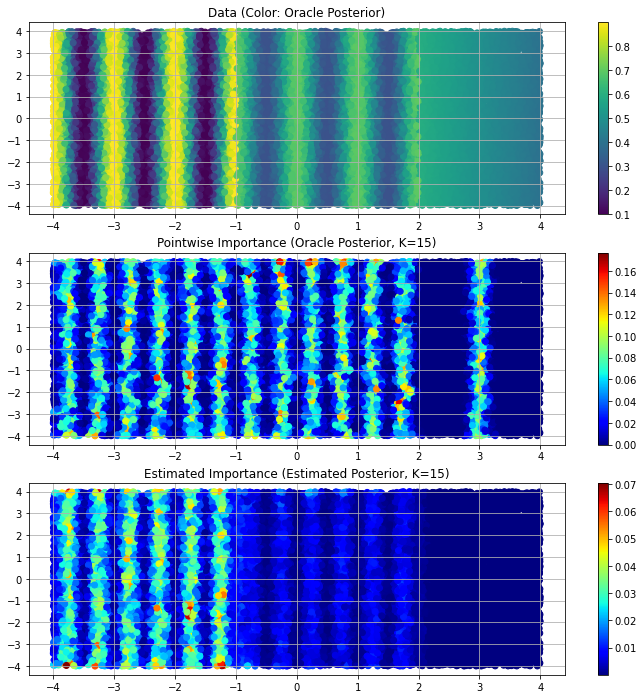

In [16]:


plt.figure(figsize=(12,12))
plt.subplot(3,1,1)
plt.scatter(xtrain[:,0], xtrain[:,1], c=tr_posterior)
plt.title('Data (Color: Oracle Posterior)')
plt.grid()
plt.colorbar()

plt.subplot(3,1,2)
plt.scatter(xtrain[:,0], xtrain[:,1], c=knn_kde_weights_estimated, cmap=plt.cm.jet)
plt.title('Pointwise Importance (Oracle Posterior, K=15)')
plt.colorbar()
plt.grid()

plt.subplot(3,1,3)
plt.scatter(xtrain[:,0], xtrain[:,1], c=knn_kde_oracle_weights, cmap=plt.cm.jet)
plt.title('Estimated Importance (Estimated Posterior, K=15)')
plt.colorbar()
plt.grid()


In [17]:
n_seed = 250
n_query = 100
active_sampsize = [n_seed + ii * n_query for ii in range(49)]

In [18]:
knn_kde_weights_estimated = knn_kde_weights_estimated.ravel()/sum(knn_kde_weights_estimated)
knn_kde_oracle_weights = knn_kde_oracle_weights.ravel()/sum(knn_kde_weights_estimated)

In [31]:
"""
UNIFORM QUERYING
Set up unlabled data 
"""
MC_ITERS = 10
nplots = 0
PLOT = False
unifcore_accs = []
unifcore_epes = []
unifcore_xents = []

''' Get KNN-KDE weights here for the posterior transfer'''
# knn_kde_weights = 1./len(xtrain)


for MC in range(MC_ITERS):
    unifcore_acc = []
    unifcore_epe = []
    unifcore_xent = []
    # active_sampsize.append(len(selected_inds))


    for sampsize in tqdm.tqdm(active_sampsize):
        
        xcore_inds = np.random.choice(np.arange(len(xtrain)), sampsize, replace=False)
        xcore = xtrain[xcore_inds]
        ycore = ytr_label[xcore_inds]
        
        mu = np.mean(xcore, axis=0)
        std = np.std(xcore, axis=0)
        _xcore = (xcore - mu)/std
        classifier = train_classifier(xtrain=_xcore, ytrain=ycore, classifier='mlp')    
        # _xstage1
        _tr_acc = evaluate_classifier(classifier, _xcore, ycore, accuracy)
        _tr_mse = evaluate_classifier(classifier, _xcore, ycore, mse)

        _xtest = (xtest - mu)/std
        test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
        test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)
        test_xent =  evaluate_classifier(classifier, _xtest, te_posterior, xentropy)

        unifcore_acc.append(1-test_acc)
        unifcore_epe.append(test_epe)
        unifcore_xent.append(test_xent)
        
    unifcore_accs.append(unifcore_acc)
    unifcore_epes.append(unifcore_epe)
    unifcore_xents.append(unifcore_xent)

100%|██████████| 49/49 [03:04<00:00,  3.76s/it]


In [20]:
"""
knncore QUERYING
Set up unlabled data 
"""
MC_ITERS = 10
nplots = 0
PLOT = False
knncore_accs = []
knncore_epes = []
knncore_xents = []

''' Get KNN-KDE weights here for the posterior transfer'''
# knn_kde_weights = 1./len(xtrain)


for MC in range(MC_ITERS):
    knncore_acc = []
    knncore_epe = []
    knncore_xent = []
    # active_sampsize.append(len(selected_inds))

    
    for sampsize in tqdm.tqdm(active_sampsize):
        
        xcore_inds = np.random.choice(np.arange(len(xtrain)), sampsize, p=knn_kde_weights_estimated, replace=False)
        xcore = xtrain[xcore_inds]
        ycore = ytr_label[xcore_inds]
        
        mu = np.mean(xcore, axis=0)
        std = np.std(xcore, axis=0)
        _xcore = (xcore - mu)/std
        classifier = train_classifier(xtrain=_xcore, ytrain=ycore, classifier='mlp')    
        # _xstage1
        _tr_acc = evaluate_classifier(classifier, _xcore, ycore, accuracy)
        _tr_mse = evaluate_classifier(classifier, _xcore, ycore, mse)

        _xtest = (xtest - mu)/std
        test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
        test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)
        test_xent =  evaluate_classifier(classifier, _xtest, te_posterior, xentropy)

        knncore_acc.append(1-test_acc)
        knncore_epe.append(test_epe)
        knncore_xent.append(test_xent)
        
    knncore_accs.append(knncore_acc)
    knncore_epes.append(knncore_epe)
    knncore_xents.append(knncore_xent)

100%|██████████| 49/49 [02:44<00:00,  3.35s/it]


In [37]:
"""
KDE+knncore QUERYING
Set up unlabled data 
"""
MC_ITERS = 10
nplots = 0
PLOT = False
estknncore_accs = []
estknncore_epes = []
estknncore_xents = []

''' Get KNN-KDE weights here for the posterior transfer'''
# knn_kde_weights = 1./len(xtrain)


for MC in range(MC_ITERS):
    estknncore_acc = []
    estknncore_epe = []
    estknncore_xent = []
    # active_sampsize.append(len(selected_inds))


    for sampsize in tqdm.tqdm(active_sampsize):
        
        xcore_inds = np.random.choice(np.arange(len(xtrain)), sampsize, p=knn_kde_weights_estimated, replace=False)
        xcore = xtrain[xcore_inds]
        ycore = ytr_label[xcore_inds]
        
        mu = np.mean(xcore, axis=0)
        std = np.std(xcore, axis=0)
        _xcore = (xcore - mu)/std
        classifier = train_classifier(xtrain=_xcore, ytrain=ycore, classifier='mlp')    
        # _xstage1
        _tr_acc = evaluate_classifier(classifier, _xcore, ycore, accuracy)
        _tr_mse = evaluate_classifier(classifier, _xcore, ycore, mse)

        _xtest = (xtest - mu)/std
        test_epe =  evaluate_classifier(classifier, _xtest, yte_label, accuracy)
        test_acc =  evaluate_classifier(classifier, _xtest, yte_label, mse)
        test_xent =  evaluate_classifier(classifier, _xtest, te_posterior, xentropy)

        estknncore_acc.append(1-test_acc)
        estknncore_epe.append(test_epe)
        estknncore_xent.append(test_xent)
        
    estknncore_accs.append(estknncore_acc)
    estknncore_epes.append(estknncore_epe)
    estknncore_xents.append(estknncore_xent)

100%|██████████| 49/49 [03:43<00:00,  4.56s/it]


Text(0, 0.5, 'Total Xentropy')

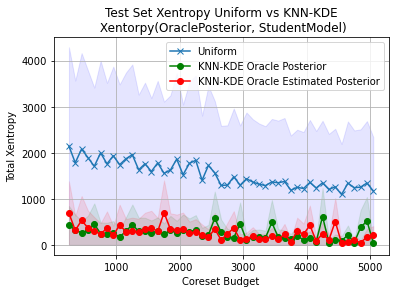

In [39]:
''' Plot Unif sampling vs uncertain sapmling '''
# unif_mean = np.mean(unif_epes, axis=0)[1:]
# unif_var = np.std(unif_epes, axis=0)[1:]
# estknncore = np.mean(active_epes, axis=0)[1:]
# active_var = np.std(active_epes, axis=0)[1:]

unifcorexent_mean = np.mean(unifcore_xents, axis=0)
knncorexent_mean = np.std(knncore_xents, axis=0)
estknncorexent_mean = np.std(estknncore_xents, axis=0)

unifcorexent_var = np.mean(unifcore_xents, axis=0)
knncorexent_var = np.std(knncore_xents, axis=0)
estknncorexent_var = np.std(estknncore_xents, axis=0)


plt.plot(active_sampsize, unifcorexent_mean, '-x', label='Uniform')
plt.fill_between(active_sampsize, unifcorexent_mean-unifcorexent_var, unifcorexent_mean+unifcorexent_var, color='b', alpha=.1)
plt.plot(active_sampsize, knncorexent_mean, '-o', label='KNN-KDE Oracle Posterior', color='g')
plt.fill_between(active_sampsize, knncorexent_mean-knncorexent_var, knncorexent_mean+knncorexent_var, color='g', alpha=.1)
plt.plot(active_sampsize, estknncorexent_mean, '-o', label='KNN-KDE Oracle Estimated Posterior', color='r')
plt.fill_between(active_sampsize, estknncorexent_mean-estknncorexent_var, estknncorexent_mean+estknncorexent_var, color='r', alpha=.1)
plt.legend()
plt.grid()
plt.title('Test Set Xentropy Uniform vs KNN-KDE\n Xentorpy(OraclePosterior, StudentModel)')
plt.xlabel('Coreset Budget')
plt.ylabel('Total Xentropy')

In [ ]:
''' Step 4: Active Mixup + Uncertainty sampling + '''

In [ ]:
''' '''